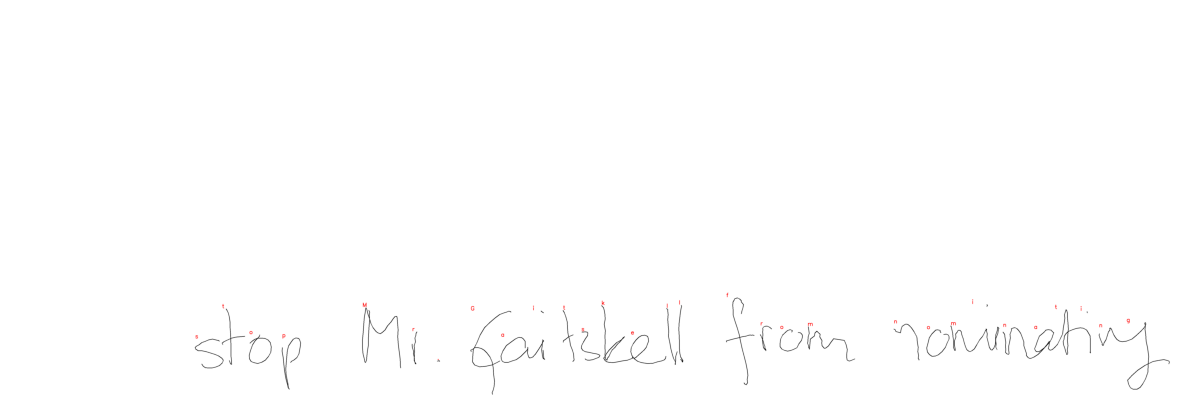

In [ ]:
import xml.etree.ElementTree as ET
import json
import os
import cv2
import matplotlib.pyplot as plt

# Putanje (meni po tvojoj strukturi)
json_path = r"C:\vi\pfe\air_writting\iam_dataset\char_annotations\trainset_segmented\a01-001w-02.xml.json"
xml_path = r"C:\vi\pfe\air_writting\iam_dataset\lineStrokes\a01\a01-001\a01-001w-02.xml"
image_path = r"C:\vi\pfe\air_writting\iam_dataset\line_images\a01\a01-001\a01-001w-02.png"  # prilagodi ako treba

# --- Učitaj XML i izvuci strokes ---
tree = ET.parse(xml_path)
root = tree.getroot()

# strokes je lista lista tačaka (x,y)
strokes = []
for stroke_elem in root.findall(".//Stroke"):
    points = []
    for point_elem in stroke_elem.findall("Point"):
        x = float(point_elem.get("x"))
        y = float(point_elem.get("y"))
        points.append((x,y))
    strokes.append(points)

# --- Učitaj JSON ---
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

segments = data["gt_segmentation"]["segments"]

# --- Priprema za crtanje ---
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Slika nije pronađena: {image_path}")

# Konvertuj sliku u RGB za matplotlib (jer OpenCV čita u BGR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Za svaki segment izračunaj bounding box
for segment in segments:
    if "inkRanges" not in segment:
        continue  # preskoči prazne segmente (npr. razmak)

    all_points = []
    for r in segment["inkRanges"]:
        start_stroke = r["startStroke"]
        end_stroke = r["endStroke"]
        start_point = r["startPoint"]
        end_point = r["endPoint"]

        for stroke_idx in range(start_stroke, end_stroke + 1):
            stroke_points = strokes[stroke_idx]

            # odredi početak i kraj tačaka u ovom stroke-u
            p_start = start_point if stroke_idx == start_stroke else 0
            p_end = end_point if stroke_idx == end_stroke else len(stroke_points) - 1

            all_points.extend(stroke_points[p_start:p_end+1])

    if not all_points:
        continue

    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)

    # nacrtaj bounding box
    '''cv2.rectangle(image_rgb,
                  (int(xmin), int(ymin)),
                  (int(xmax), int(ymax)),
                  color=(255,0,0), thickness=2) '''

    # napiši karakter (substring) na početku bboxa
    cv2.putText(image_rgb, segment["substring"], (int(xmin), int(ymin)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

# --- Prikaži sliku sa bbox-ovima ---
plt.figure(figsize=(15,8))
plt.imshow(image_rgb)
plt.axis("off")
plt.show() 
